# Algorithm completeness
This code shows completeness of the algorith.
It starts with builind a toy graph where origins are nearby and destinations are nearby too. 
They depart every 5 seconds, so in theory all trips shall be shareable in any combination.
Here we test it.
In such setting even for small sets size quickly becomes huge.

We tested up to 8 trips, which can be shared in 219192 rides

----

## ExMAS
> Exact Matching of Attractive Shared rides (ExMAS) for system-wide strategic evaluations
> 
> Kucharski R., Cats O. ,_Transportation Research Part: B_, 2020

---
#### Walkthrough

In [1]:
import os
cwd = os.getcwd()

In [2]:
os.chdir(os.path.join(cwd,'..'))
import ExMAS
import ExMAS_utils

In [3]:
from ExMAS_utils import inData as inData

### prepare

1. __load the default config__ (see more details in `ExMAS/notebooks/01 configuration.ipynb`)

In [4]:
params = ExMAS_utils.get_config('data/configs/default.json') # load the default 

2. __load the network__ (see more details in `ExMAS/notebooks/02 NetworkGraphs.ipynb`)

In [5]:
inData = ExMAS_utils.load_G(inData, params, stats=True)  # download the graph

3. __generate trip requests__ (see more details in `ExMAS/notebooks/03 Demand Generation.ipynb`)

In [6]:
inData = ExMAS_utils.generate_demand(inData, params)

In [7]:
import networkx as nx
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.collections import LineCollection
import pulp
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%load_ext autoreload
%autoreload 2

params.horizon = 600

#inData = load_G(inData, params, stats = True) # download the graph for the 'params.city' (Delft) and calc the skim matrices

In [9]:
params.t0 = pd.Timestamp.now()
params.nP = 6 # number of trips
params.simTime = 0.5 #hours
params.avg_speed = 8
params.shared_discount = 0.3
params.delay_value = 1.5
params.WtS = 1.1
params.price = 1 #eur/km
params.VoT = 0.0035 #eur/s
params.matching_obj = 'u_veh' #minimize VHT for vehicles
params.pax_delay = 30
params.horizon = -1
params.max_degree = 3
params.nP = params.nP

make graph

In [10]:
G = nx.DiGraph()
odl1 = 50
odl2 = 10000
G.add_node(0,data='')
G.add_node(1,data='')
G.add_edge(0,1,length=odl2)
G.add_edge(1,0,length=odl2)
for i in range(params.nP):
    G.add_node(100+i, data='')
    G.add_edge(100+i,0,length=odl1)
    G.add_edge(0,100+i,length=odl1)
    G.add_node(200+i, data='')
    G.add_edge(200+i,1,length=odl1)
    G.add_edge(1,200+i,length=odl1)    
inData.G = G
inData.nodes = pd.DataFrame.from_dict(dict(inData.G.nodes()), orient='index')

calc skim

In [11]:
skim_generator = nx.all_pairs_dijkstra_path_length(G, weight = 'length') 
skim_dict = dict(skim_generator) #filled dict is more usable
skim = pd.DataFrame(skim_dict).T # and dataframe is more intuitive
skim = skim.sort_index()
skim = skim.T.sort_index()
skim = skim.T
inData.skim = skim
inData.stats['center']=0

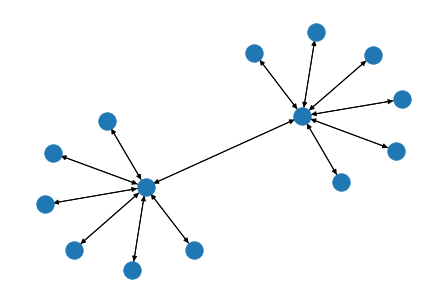

In [12]:
nx.draw(G)

make requests

In [13]:
inData = ExMAS_utils.generate_demand(inData, params)
inData.requests.sort_index()
inData.requests.origin=list(range(100,100+params.nP))
inData.requests.destination=list(range(200,200+params.nP))
inData.requests.treq
params.t0 = pd.to_datetime('15:00')
inData.requests.treq = [params.t0+pd.Timedelta(str(5*i)+'s') for i in range(params.nP)]
inData.requests['dist'] = inData.requests.apply(lambda request: 
                                                inData.skim.loc[request.origin,request.destination],axis=1)
inData.requests['ttrav'] = inData.requests.apply(lambda request: pd.Timedelta(request.dist,'s').floor('s'),axis=1)
inData.requests.head()

,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id
2,100,200,2020-07-03 15:00:00,NaN,02:48:20,2020-07-03 12:34:43.766175,NaN,10100,2
3,101,201,2020-07-03 15:00:05,NaN,02:48:20,2020-07-03 12:35:14.766175,NaN,10100,3
6,102,202,2020-07-03 15:00:10,NaN,02:48:20,2020-07-03 12:36:36.766175,NaN,10100,6
4,103,203,2020-07-03 15:00:15,NaN,02:48:20,2020-07-03 12:46:32.766175,NaN,10100,4
1,104,204,2020-07-03 15:00:20,NaN,02:48:20,2020-07-03 12:47:23.766175,NaN,10100,1


## Calc shareability
---

03-07-20 12:43:57-INFO-Initializing pairwise trip shareability between 6 and 6 trips.
03-07-20 12:43:57-INFO-creating combinations
03-07-20 12:43:57-INFO-30	 nR*(nR-1)
03-07-20 12:43:57-INFO-30	departure compatibility
03-07-20 12:43:57-INFO-30	origins shareability
03-07-20 12:43:57-INFO-30	utility for i
03-07-20 12:43:57-INFO-30	utility for j
03-07-20 12:43:57-INFO-30	LIFO pairs
03-07-20 12:43:57-INFO-Reduction of feasible pairs by 0.00%


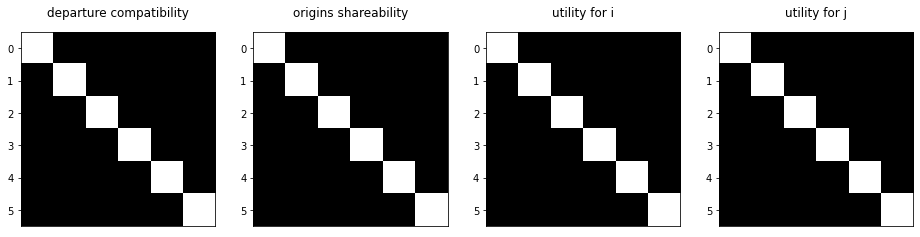

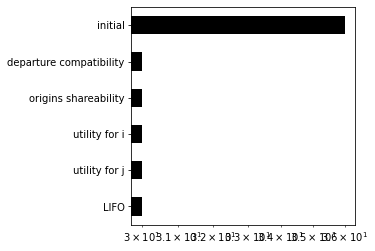

03-07-20 12:43:58-INFO-Degree 2 	Completed
03-07-20 12:43:58-INFO-trips to extend at degree 2 : 60
03-07-20 12:43:58-INFO-At degree 2 feasible extensions found out of 240 searched
03-07-20 12:43:58-INFO-Degree 3 	Completed
03-07-20 12:43:58-INFO-trips to extend at degree 3 : 240
03-07-20 12:43:59-INFO-At degree 3 feasible extensions found out of 720 searched
03-07-20 12:43:59-INFO-Degree 4 	Completed
03-07-20 12:43:59-INFO-trips to extend at degree 4 : 720
03-07-20 12:44:01-INFO-At degree 4 feasible extensions found out of 1440 searched
03-07-20 12:44:01-INFO-Degree 5 	Completed
03-07-20 12:44:01-INFO-trips to extend at degree 5 : 1440
03-07-20 12:44:04-INFO-At degree 5 feasible extensions found out of 1440 searched
03-07-20 12:44:04-INFO-Degree 6 	Completed
03-07-20 12:44:04-INFO-trips to extend at degree 6 : 1440
03-07-20 12:44:04-INFO-At degree 6 feasible extensions found out of 0 searched
03-07-20 12:44:04-INFO-Degree 7 	Completed
03-07-20 12:44:04-INFO-Max degree reached 7
03-07-2

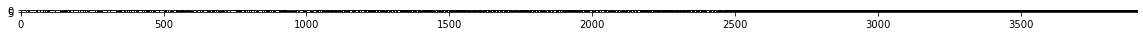

03-07-20 12:44:13-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,572 
reduced by matching to:                1,682
03-07-20 12:44:13-INFO-Calculations  completed
03-07-20 12:44:13-INFO-DotMap(VehHourTrav=1682, VehHourTrav_ns=7572, PassHourTrav=8832, PassHourTrav_ns=7572, PassUtility=79.8189, PassUtility_ns=87.10199999999999, mean_lambda=0.7778658214474379, revenue_s=5300.4, revenue_ns=7572, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=0, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=1, shared_ratio=1.0, fleet_size_nonshared=6.0, fleet_size_shared=1.0, lambda_shared=0.7778658214474379)


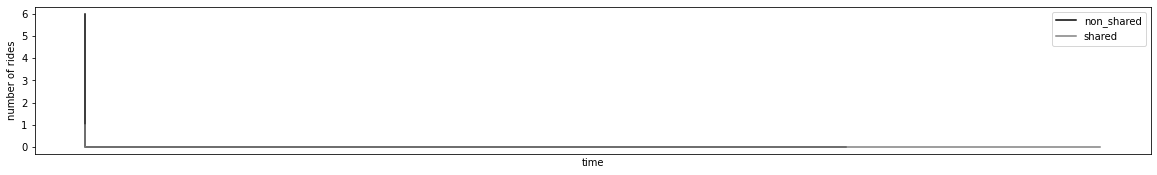

In [14]:
params.max_degree = 7
params.pax_delay=60
inData = ExMAS.main(inData,params, plot=True)

In [18]:
inData.sblts.res.to_frame().T

,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,...,TRIPLES,QUADRIPLES,QUINTETS,PLUS5,shared_ratio,fleet_size_nonshared,fleet_size_shared,lambda_shared,_typ,dtype
0,1682,7572,8832,7572,79.819,87.102,0.778,5300.400,7572,-0.300,...,0,0,0,1,1.000,6.000,1.000,0.778,"DotMap(_typ=DotMap(), __next__=DotMap())","DotMap(_typ=DotMap(), __next__=DotMap())"


In [19]:
inData.sblts.schedule

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected
3627,"[3, 4, 1, 2, 5, 0]",79.819,1682,100,"[14.241587500000001, 13.947062500000001, 13.25...","[11.5, 72, 72, 72, 72, 72, 1262, 12, 12, 12, 1...","[3, 4, 1, 2, 5, 0]","[4, 3, 1, 2, 5, 0]",6,3627,0.778,7572,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1


In [20]:
inData.sblts.rides.shape

(3906, 14)

---
(c) Rafał Kucharski, Delft, 2020